In [1]:
# SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# FLUX.1 [dev] Pipeline Optimized with <span style='color: #76B900'>TensorRT-RTX</span>

In [2]:
import sys
import os
from pathlib import Path
import gc
import torch
from dataclasses import dataclass
from typing import Optional, List, Tuple

# Resolves tqdm import issue on Windows
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

# Add ../../demo/ to current path
if "__session__" in locals():
    sys.path.append(str(Path(os.path.realpath(__session__)).parent.parent)) # noqa: F821

from ipywidgets import Output
from pipelines.flux_pipeline import FluxPipeline
from utils.notebook_utils import printmd, display_image_from_path, markdown_bold_green_format

In [3]:
DEMO_CACHE_DIR = "./demo_cache/"  # Where the demo ONNX, engine, and metadata will be stored
DEMO_CACHE_MODE = "full"  # "full" or "lean" depending on whether you would like files to be cleaned up after every section of the demo
HF_TOKEN = "YOUR_HF_TOKEN"  # HuggingFace Token with access to the FLUX.1[dev] model repo
LOG_LEVEL = "INFO"
DEVICE = "cuda"
assert HF_TOKEN != "YOUR_HF_TOKEN", "Please set your HuggingFace token in the HF_TOKEN variable" 

## Demo Helper Functions


In [4]:
@dataclass
class GenerationConfig:
    """Configuration for image generation parameters."""
    height: int = 512
    width: int = 512
    batch_size: int = 1
    seed: int = 1353
    num_inference_steps: int = 50
    guidance_scale: float = 4.5
    prompt: str = "A prominently-displayed sign that reads precisely the words 'TensorRT - RTX' in green with an impressive backdrop"


def prepare_pipeline(
    config: GenerationConfig,
    precision: str = "fp8",
    shape_mode: str = "static",
    enable_cudagraphs: bool = False,
    enable_runtime_cache: bool = True,
    low_vram: bool = False,
    verbose: bool = True,
) -> Tuple[FluxPipeline, dict]:
    """
    Initialize and load FLUX pipeline with specified optimizations.
    
    Args:
        config: GenerationConfig with image parameters
        precision: "fp8", "fp4", or "bf16" for transformer
        shape_mode: "static" or "dynamic"
        enable_cudagraphs: Enable built-in cudagraphs
        enable_runtime_cache: Enable runtime caching
        low_vram: Enable low-VRAM mode (CPU offloading)
        verbose: Print initialization messages
        
    Returns:
        (pipeline, jit_times_dict)
    """
    if verbose:
        mode_desc = f"**{precision.upper()}** Precision"
        if shape_mode == "dynamic":
            mode_desc += " with **Dynamic Shapes**"
        if enable_cudagraphs:
            mode_desc += " + **Cudagraphs**"
        if enable_runtime_cache:
            mode_desc += " + **Runtime Cache**"
        if low_vram:
            mode_desc += " + **Low-VRAM Mode**"
        printmd(f"Initializing Flux pipeline with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in {mode_desc}...")
    
    pipeline = FluxPipeline(
        cache_dir=DEMO_CACHE_DIR,
        device=DEVICE,
        verbose=False,
        cache_mode=DEMO_CACHE_MODE,
        guidance_scale=config.guidance_scale,
        num_inference_steps=config.num_inference_steps,
        hf_token=HF_TOKEN,
        log_level=LOG_LEVEL,
        low_vram=low_vram,
        enable_runtime_cache=enable_runtime_cache,
        cuda_graph_strategy="whole_graph_capture" if enable_cudagraphs else "disabled",
    )
    
    if verbose:
        printmd("**Building and Loading engines**...")
    jit_times = pipeline.load_engines(
        transformer_precision=precision,
        opt_batch_size=config.batch_size,
        opt_height=config.height,
        opt_width=config.width,
        shape_mode=shape_mode,
    )
    
    if verbose:
        printmd("**Loading resources**...")
    pipeline.load_resources(
        batch_size=config.batch_size,
        height=config.height,
        width=config.width,
    )
    
    if verbose:
        for model, jit_time in jit_times.items():
            printmd(markdown_bold_green_format("JIT Compilation") +
                    f" + Execution Context Creation Time for **{model}**: {round(jit_time, 2)} seconds")
    
    return pipeline, jit_times


# 1. Quickstart

### Overview
We provide a demonstration of running FLUX.1 [dev] in a variety of precisions. It showcases the steps involved in accelerating inference in real-world model pipelines using TensorRT-RTX.

> **Note:** This end-to-end notebook was verified on an NVIDIA Blackwell GPU. See _"Transformer Precision Options"_ of `demo/README.md` for more compatibility details.

#### Features Highlighted

1. **JIT Compilation**: Specializes the TensorRT-RTX engine to the GPU on which you are running inference
2. **Dynamic Shape Specialization**: Substitution of performant, shape-specialized kernels in the background based on input shapes observed at runtime
3. **Cudagraphs**: Reduce kernel launch overhead with automatic support for capture and replay of Cudagraphs, including for dynamic shapes cases
4. **Runtime Caching**: Faster JIT times through caching kernel compilations
5. **Quantization**: Faster inference and smaller engines using FP8 and NVFP4 data types
    1. _For convenience, our demonstration uses pre-quantized models downloaded from HuggingFace. We recommend using NVIDIA TensorRT Model Optimizer for quantizing models for deployment with TensorRT-RTX._
6. **Low-VRAM Mode**: Pipeline setting where components are offloaded to CPU when not in use, to conserve GPU memory

> **Note:**  We recommend running using a GPU with 32GB of memory; the NVFP4 quantized model run in **Low-VRAM Mode** can run on GPUs with 16GB of memory.

#### Configure Parameters
- `height` = Height of the output image (generally keep to multiples of 16)
- `width` = Width of the output image (generally keep to multiples of 16)
- `batch_size`: Number of images to generate per prompt
- `seed`: Parameter for random initializations (try different values to vary your outputs)
- `num_inference_steps`: How many iterations of denoising to run on the image (generally, higher = better quality)
- `guidance_scale`: Proximity of the image to the input prompt, in meaning (generally, higher = more fidelity to the input prompt)
- `prompt`: The text describing the desired content of the image

#### Initialize the Pipeline
```python
# Initialize a pipeline instance
pipeline = FluxPipeline( ... )
# Load engines
pipeline.load_engines( ... )
# Load resources (input/output buffers, workspace)
pipeline.load_resources( ... )
# Run Inference
pipeline.infer( ... )
```

#### Notes and Troubleshooting
- Some of the cells in the notebook may take a long time to execute (5-10 minutes).
  - These are copying files and building engines for multiple large component models in the FLUX pipeline and thus require a large amount of time to generate.
- Some of the model precisions in this notebook may not work on all GPUs.
  - FP8 is expected to work on Ada (Compute Capability 89) and later GPUs
  - FP4 is expected to work on Blackwell (Compute Capability 120) and later GPUs
- Some of the sections of this notebook may not work on all GPUs, due to memory constraints.
  - If you observe Out-Of-Memory issues, try the last sections, **Further Quantization** and **Low-VRAM Mode** first.
- If you observe high disk space usage in the cache, consider using `DEMO_CACHE_MODE = "lean"`, which will delete unused models and engines.
  - With lean cache mode, we observe ~55-60 GB of disk space usage for FP8 models + engines and ~30-35 GB of disk space usage for FP4 models + engines
- If you switch cache modes and see runtime issues or observe unexpected errors with your built engines, try deleting the cache directory and re-running.

## Model Configuration

In [5]:
config = GenerationConfig(
    height=512,
    width=512,
    batch_size=1,
    seed=1353,
    num_inference_steps=50,
    guidance_scale=4.5,
    prompt="A prominently-displayed sign that reads precisely the words 'TensorRT - RTX' in green with an impressive backdrop"
)

## Pipeline Initialization

In [6]:
pipeline, _ = prepare_pipeline(
    config=config,
    precision="fp8",
    shape_mode="static",
    enable_runtime_cache=True
)

Initializing Flux pipeline with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision + **Runtime Cache**...

[2025-10-28 12:20:48] [rtx_demo.utils.path_manager] [INFO] PathManager initialized - Cache: C:\tmp\demo_cache, Mode: full
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


**Building and Loading engines**...

[2025-10-28 12:20:49] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Shape configuration: {'clip_text_encoder': 'static', 't5_text_encoder': 'static', 'transformer': 'static', 'vae_decoder': 'static'}


[W] 'colored' module is not installed, will not use colors when logging. To enable colors, please install the 'colored' module: python3 -m pip install colored
[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_clip_text_encoder\bf16\flux_clip_text_encoder_static.engine
[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_t5_text_encoder\bf16\flux_t5_text_encoder_static.engine
[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_transformer\fp8\flux_transformer_static.engine


[2025-10-28 12:20:57] [rtx_demo.utils.engine] [INFO] Building TensorRT engine for C:\tmp\demo_cache\shared\onnx\flux_vae_decoder\bf16\flux_vae_decoder.onnx: C:\tmp\demo_cache\shared\engines\flux_vae_decoder\bf16\flux_vae_decoder_static.engine
[2025-10-28 12:20:58] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Activating engines...


[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_vae_decoder\bf16\flux_vae_decoder_static.engine


[2025-10-28 12:20:59] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-10-28 12:21:00] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-10-28 12:21:30] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-10-28 12:21:33] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Engines activated successfully


**Loading resources**...

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **clip_text_encoder**: 0.92 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **t5_text_encoder**: 0.92 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **transformer**: 29.71 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **vae_decoder**: 3.34 seconds

**Prompt**: A prominently-displayed sign that reads precisely the words 'TensorRT - RTX' in green with an impressive backdrop


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision


[I] Starting image generation with dimensions: 512 x 512 and 50 denoising iterations
[I] Using guidance_scale 4.5 and seed 1353


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-10-28 12:21:38] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: C:/tmp/demo_cache/flux_demo_1.png with shape (512, 512, 3)


**Generated Image(s) in 5.06s**


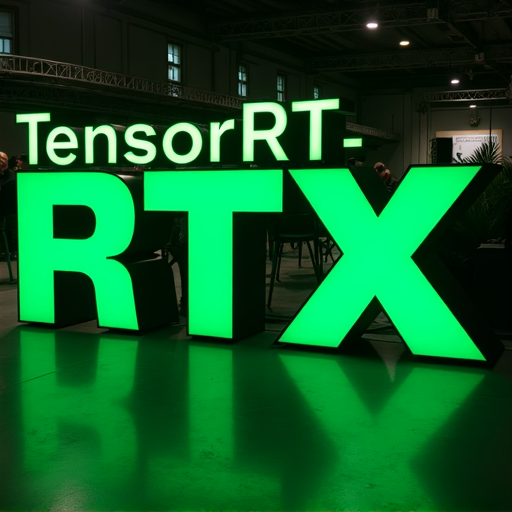

In [7]:
printmd(f"**Prompt**: {config.prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP8** Precision\n")
print(f"[I] Starting image generation with dimensions: {config.width} x {config.height} and {config.num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {config.guidance_scale} and seed {config.seed}")

_, image_paths = pipeline.infer(prompt=config.prompt,
                                batch_size=config.batch_size,
                                height=config.height,
                                width=config.width,
                                seed=config.seed,
                                num_inference_steps=config.num_inference_steps,
                                guidance_scale=config.guidance_scale,
                                save_path=DEMO_CACHE_DIR)
timing_dict = pipeline.timing_data.to_dict()

printmd(f"**Generated Image(s) in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**")
for image_path in image_paths:
    display_image_from_path(image_path)

with Output():
    pipeline.cleanup(); del pipeline; torch.cuda.empty_cache(); gc.collect()

# 2. Dynamic Shape Specialization
<span style='color: #76B900'>TensorRT-RTX</span> also introduces new dynamic shapes features. At runtime, when the execution context is created, the JIT optimizations generate fallback kernels that can run inference on the entire range of input shapes. Then, as new shapes are encountered during inference, shape-specialized kernels are generated on the fly. These specialized kernels are compiled in a background thread while ‌initial inference requests are serviced using fallback kernels, then substituted in when ready for an efficient boost in performance.

In [8]:
config = GenerationConfig(
    height=448,
    width=448,
    batch_size=1,
    seed=1001,
    num_inference_steps=75,
    guidance_scale=4.5,
    prompt="A prominently-displayed sign that reads precisely the words 'TensorRT - RTX' in green with an impressive backdrop"
)

In [9]:
pipeline, initial_jit_times = prepare_pipeline(
    config=config,
    precision="fp8",
    shape_mode="dynamic",  #### Enabled dynamic shapes here ####
    enable_runtime_cache=True
)

Initializing Flux pipeline with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision with **Dynamic Shapes** + **Runtime Cache**...

[2025-10-28 12:21:43] [rtx_demo.utils.path_manager] [INFO] PathManager initialized - Cache: C:\tmp\demo_cache, Mode: full


**Building and Loading engines**...

[2025-10-28 12:21:44] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Setting VAE Decoder to static shape to reduce VRAM usage
[2025-10-28 12:21:44] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Shape configuration: {'clip_text_encoder': 'dynamic', 't5_text_encoder': 'dynamic', 'transformer': 'dynamic', 'vae_decoder': 'static'}


[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_clip_text_encoder\bf16\flux_clip_text_encoder_dynamic.engine
[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_t5_text_encoder\bf16\flux_t5_text_encoder_dynamic.engine
[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_transformer\fp8\flux_transformer_dynamic.engine


[2025-10-28 12:21:52] [rtx_demo.utils.engine] [INFO] Building TensorRT engine for C:\tmp\demo_cache\shared\onnx\flux_vae_decoder\bf16\flux_vae_decoder.onnx: C:\tmp\demo_cache\shared\engines\flux_vae_decoder\bf16\flux_vae_decoder_static.engine
[2025-10-28 12:21:54] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Activating engines...
[2025-10-28 12:21:54] [rtx_demo.utils.engine] [INFO] Loading runtime cache from C:/tmp/demo_cache/runtime.cache
[2025-10-28 12:21:54] [rtx_demo.utils.engine] [INFO] Deserializing runtime cache


[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_vae_decoder\bf16\flux_vae_decoder_static.engine


[2025-10-28 12:21:57] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-10-28 12:21:58] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-10-28 12:22:37] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-10-28 12:22:40] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Engines activated successfully


**Loading resources**...

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **clip_text_encoder**: 1.79 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **t5_text_encoder**: 1.55 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **transformer**: 39.4 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **vae_decoder**: 2.9 seconds

**Prompt**: A prominently-displayed sign that reads precisely the words 'TensorRT - RTX' in green with an impressive backdrop


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision with Dynamic Shapes


[I] Starting image generation with dimensions: 448 x 448 and 75 denoising iterations
[I] Using guidance_scale 4.5 and seed 1001


Denoising:   0%|          | 0/75 [00:00<?, ?it/s]

[2025-10-28 12:22:50] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: C:/tmp/demo_cache/flux_demo_1.png with shape (448, 448, 3)


**<span style='color: #0071C5; font-weight: bold'>Dynamic Shape Specialization Improvement: 448 x 448</span>**

Transformer Iteration 1: 1818.88ms (Fallback kernels + Specialization Begins)

Transformer Iteration 2: 174.04ms (Specializing kernels ...)

Transformer Iteration 3: 170.57ms (Specializing kernels ...)

Transformer Iteration 75: 60.43ms (Specialized kernels)

**Fallback-to-Specialized Kernels** - <span style='color: #890C58; font-weight: bold'> Speedup: **30.1x</span>**

**Generated Image(s) in 9.88s**


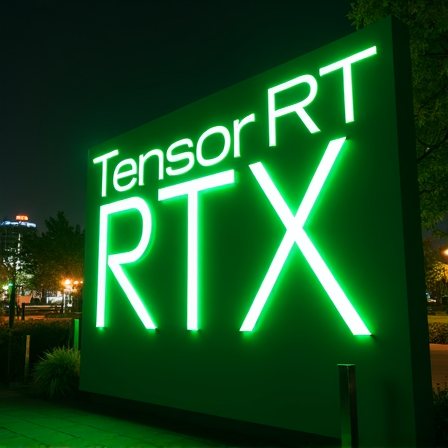

In [10]:
printmd(f"**Prompt**: {config.prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP8** Precision with Dynamic Shapes\n")
print(f"[I] Starting image generation with dimensions: {config.width} x {config.height} and {config.num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {config.guidance_scale} and seed {config.seed}")

_, image_paths = pipeline.infer(prompt=config.prompt,
                                batch_size=config.batch_size,
                                height=config.height,
                                width=config.width,
                                seed=config.seed,
                                num_inference_steps=config.num_inference_steps,
                                guidance_scale=config.guidance_scale,
                                save_path=DEMO_CACHE_DIR)
timing_dict = pipeline.timing_data.to_dict()

printmd(f"**<span style='color: #0071C5; font-weight: bold'>Dynamic Shape Specialization Improvement: {config.width} x {config.height}</span>**", newlines=2)
printmd(f"Transformer Iteration 1: {round(timing_dict['transformer_runtimes_ms'][0], 2)}ms (Fallback kernels + Specialization Begins)")
printmd(f"Transformer Iteration 2: {round(timing_dict['transformer_runtimes_ms'][1], 2)}ms (Specializing kernels ...)")
printmd(f"Transformer Iteration 3: {round(timing_dict['transformer_runtimes_ms'][2], 2)}ms (Specializing kernels ...)")
printmd(f"Transformer Iteration {config.num_inference_steps}: {round(timing_dict['transformer_runtimes_ms'][-1], 2)}ms (Specialized kernels)")
printmd("**Fallback-to-Specialized Kernels** - <span style='color: #890C58; font-weight: bold'> Speedup: "
        f"**{round(timing_dict['transformer_runtimes_ms'][0]/timing_dict['transformer_runtimes_ms'][-1], 2)}x</span>**")

initial_cache_inference_time = timing_dict['total_e2e_runtime_ms'] / 1000
printmd(f"**Generated Image(s) in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**", newlines=2)
for image_path in image_paths:
    display_image_from_path(image_path)

## Dynamic Shape Steady State
Now that the above shapes have been encountered at inference time, new runs of similar shapes within the execution context will have the specialized kernels available from the get-go:

**Prompt**: A prominently-displayed sign that reads precisely the words 'TensorRT - RTX' in green with an impressive backdrop


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision with Dynamic Shapes


[I] Starting image generation with dimensions: 448 x 448 and 50 denoising iterations
[I] Using guidance_scale 4.5 and seed 1001


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-10-28 12:22:54] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: C:/tmp/demo_cache/flux_demo_1.png with shape (448, 448, 3)


**<span style='color: #0071C5; font-weight: bold'>Dynamic Shape Specialization Steady State: 448 x 448</span>**

Transformer Iteration 1: 64.06ms (Specialized kernels, GPU Warmup)

Transformer Iteration 2: 59.98ms (Specialized kernels)

Transformer Iteration 3: 61.27ms (Specialized kernels)

**Generated Image(s) in 3.13s**


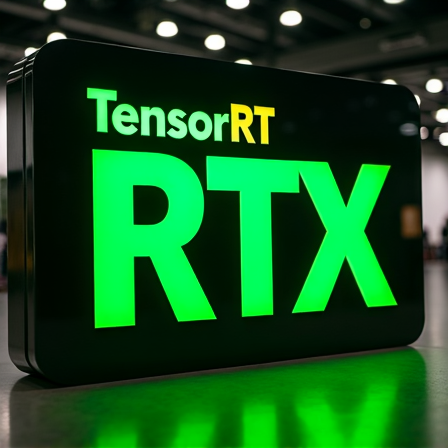

In [11]:
num_inference_steps = 50
printmd(f"**Prompt**: {config.prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP8** Precision with Dynamic Shapes\n")
print(f"[I] Starting image generation with dimensions: {config.width} x {config.height} and {num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {config.guidance_scale} and seed {config.seed}")

_, image_paths = pipeline.infer(prompt=config.prompt,
                                batch_size=config.batch_size,
                                height=config.height,
                                width=config.width,
                                seed=config.seed + 40,
                                num_inference_steps=num_inference_steps,
                                guidance_scale=config.guidance_scale,
                                save_path=DEMO_CACHE_DIR)
timing_dict = pipeline.timing_data.to_dict()

printmd(f"**<span style='color: #0071C5; font-weight: bold'>Dynamic Shape Specialization Steady State: {config.width} x {config.height}</span>**", newlines=2)
printmd(f"Transformer Iteration 1: {round(timing_dict['transformer_runtimes_ms'][0], 2)}ms (Specialized kernels, GPU Warmup)")
printmd(f"Transformer Iteration 2: {round(timing_dict['transformer_runtimes_ms'][1], 2)}ms (Specialized kernels)")
printmd(f"Transformer Iteration 3: {round(timing_dict['transformer_runtimes_ms'][2], 2)}ms (Specialized kernels)")

pre_cuda_graphs_time = timing_dict['total_e2e_runtime_ms'] / 1000
printmd(f"**Generated Image(s) in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**", newlines=2)
for image_path in image_paths:
    display_image_from_path(image_path)

with Output():
    pipeline.cleanup(); del pipeline; torch.cuda.empty_cache(); gc.collect()

# 3. Cudagraphs
<span style='color: #76B900'>TensorRT-RTX</span> introduces _Built-in Cudagraphs_, a feature which further accelerates workloads by automatically batching kernel launches and reducing enqueue overhead. Built-in Cudagraphs integrates seamlessly with dynamic shapes, delivering improved performance _especially_ on enqueue-bound workloads and Windows machines with Hardware Scheduling enabled.

In [12]:
printmd("**Reloading engines with Cudagraphs + Dynamic Shapes Enabled**...")
with Output():
    pipeline, _ = prepare_pipeline(
        config=config,
        precision="fp8",
        shape_mode="dynamic",
        enable_cudagraphs=True,  #### Enabled cudagraphs here ####
        enable_runtime_cache=True,
        verbose=False
    )
printmd("Engines Successfully Reloaded")

**Reloading engines with Cudagraphs + Dynamic Shapes Enabled**...

Engines Successfully Reloaded

**Prompt**: A prominently-displayed sign that reads precisely the words 'TensorRT - RTX' in green with an impressive backdrop


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision with Runtime Caching and Cudagraphs


[I] Starting image generation with dimensions: 448 x 448 and 50 denoising iterations
[I] Using guidance_scale 4.5 and seed 1001
[I] Warming up Cudagraph Cache


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-10-28 12:23:23] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: C:/tmp/demo_cache/flux_demo_1.png with shape (448, 448, 3)


**Generated Image(s) in 2.96s**


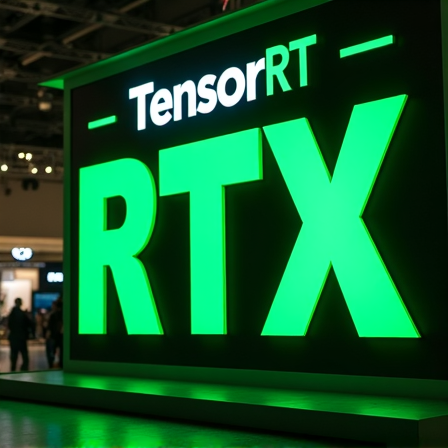

**Cudagraphs** - <span style='color: #890C58; font-weight: bold'>Speedup: 1.06x</span>

**Note:** Performance improvement from Cudagraphs is generally more pronounced on (1) Windows machines with Hardware Scheduling Enabled and (2) Enqueue-bound workloads.

In [13]:
printmd(f"**Prompt**: {config.prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP8** Precision with Runtime Caching and Cudagraphs\n")
print(f"[I] Starting image generation with dimensions: {config.width} x {config.height} and {num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {config.guidance_scale} and seed {config.seed}")

# Warmup CG
print(f"[I] Warming up Cudagraph Cache")
with Output():
    pipeline.infer(prompt=config.prompt, batch_size=config.batch_size, height=config.height,
                   width=config.width, seed=config.seed + 2, num_inference_steps=num_inference_steps,
                   guidance_scale=config.guidance_scale, save_path=DEMO_CACHE_DIR)

_, image_paths = pipeline.infer(prompt=config.prompt,
                                batch_size=config.batch_size,
                                height=config.height,
                                width=config.width,
                                seed=config.seed + 53,
                                num_inference_steps=num_inference_steps,
                                guidance_scale=config.guidance_scale,
                                save_path=DEMO_CACHE_DIR)

timing_dict = pipeline.timing_data.to_dict()
post_cuda_graphs_time = timing_dict['total_e2e_runtime_ms'] / 1000
printmd(f"**Generated Image(s) in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**")
for image_path in image_paths:
    display_image_from_path(image_path)

printmd(f"**Cudagraphs** - <span style='color: #890C58; font-weight: bold'>Speedup: "
        f"{round(pre_cuda_graphs_time/post_cuda_graphs_time, 2)}x</span>")
printmd(f"**Note:** Performance improvement from Cudagraphs is generally more pronounced on (1) Windows machines with Hardware Scheduling Enabled and (2) Enqueue-bound workloads.")

with Output():
    pipeline.cleanup(); del pipeline; torch.cuda.empty_cache(); gc.collect()

# 4. Runtime Caching
<span style='color: #76B900'>TensorRT-RTX</span> introduces _Runtime Caching_, a feature which enables accelerated JIT compilation using a serializable cache. Here, we feature the JIT-time improvement observed when utilizing the runtime cache.

In [14]:
config = GenerationConfig(
    height=448,
    width=448,
    batch_size=1,
    seed=1001,
    num_inference_steps=50,
    guidance_scale=4.0,
    prompt="A cat meanders down a dimly lit alleyway in a large city."
)

In [15]:
printmd("**Reloading engines with Runtime Cache**...")

pipeline, rt_cache_jit_times = prepare_pipeline(
    config=config,
    precision="fp8",
    shape_mode="dynamic",
    enable_runtime_cache=True #### Enabled runtime cache here ####
)

rt_cache_jit_time_sum = sum(rt_cache_jit_times.values())
initial_cache_jit_time_sum = sum(initial_jit_times.values())

printmd(markdown_bold_green_format("Runtime Cache JIT Compilation") +
        f" + Execution Context Creation Time for **FLUX.1 [dev] Pipeline**: {round(rt_cache_jit_time_sum, 2)} seconds, "
        f"a **{round(initial_cache_jit_time_sum / rt_cache_jit_time_sum, 2)}x** Improvement")

**Reloading engines with Runtime Cache**...

Initializing Flux pipeline with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision with **Dynamic Shapes** + **Runtime Cache**...

[2025-10-28 12:23:32] [rtx_demo.utils.path_manager] [INFO] PathManager initialized - Cache: C:\tmp\demo_cache, Mode: full


**Building and Loading engines**...

[2025-10-28 12:23:33] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Setting VAE Decoder to static shape to reduce VRAM usage
[2025-10-28 12:23:33] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Shape configuration: {'clip_text_encoder': 'dynamic', 't5_text_encoder': 'dynamic', 'transformer': 'dynamic', 'vae_decoder': 'static'}


[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_clip_text_encoder\bf16\flux_clip_text_encoder_dynamic.engine
[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_t5_text_encoder\bf16\flux_t5_text_encoder_dynamic.engine
[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_transformer\fp8\flux_transformer_dynamic.engine


[2025-10-28 12:23:41] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Activating engines...
[2025-10-28 12:23:41] [rtx_demo.utils.engine] [INFO] Loading runtime cache from C:/tmp/demo_cache/runtime.cache
[2025-10-28 12:23:41] [rtx_demo.utils.engine] [INFO] Deserializing runtime cache


[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_vae_decoder\bf16\flux_vae_decoder_static.engine


[2025-10-28 12:23:43] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-10-28 12:23:44] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-10-28 12:23:45] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-10-28 12:23:45] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Engines activated successfully


**Loading resources**...

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **clip_text_encoder**: 0.14 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **t5_text_encoder**: 0.18 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **transformer**: 1.66 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **vae_decoder**: 0.06 seconds

<span style='color: #76B900; font-weight: bold'>Runtime Cache JIT Compilation</span> + Execution Context Creation Time for **FLUX.1 [dev] Pipeline**: 2.05 seconds, a **22.27x** Improvement

**Prompt**: A cat meanders down a dimly lit alleyway in a large city.


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP8** Precision with Runtime Caching


[I] Starting image generation with dimensions: 448 x 448 and 50 denoising iterations
[I] Using guidance_scale 4.0 and seed 1001


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-10-28 12:23:50] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: C:/tmp/demo_cache/flux_demo_1.png with shape (448, 448, 3)


**Generated Image(s) in 4.59s**


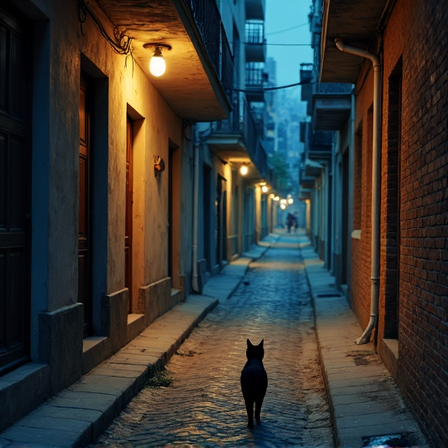

**Runtime Cache E2E Pipeline** - <span style='color: #890C58; font-weight: bold'>Speedup: 8.37x</span>

In [16]:
printmd(f"**Prompt**: {config.prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP8** Precision with Runtime Caching\n")
print(f"[I] Starting image generation with dimensions: {config.width} x {config.height} and {config.num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {config.guidance_scale} and seed {config.seed}")

_, image_paths = pipeline.infer(prompt=config.prompt,
                                batch_size=config.batch_size,
                                height=config.height,
                                width=config.width,
                                seed=config.seed + 5,
                                num_inference_steps=config.num_inference_steps,
                                guidance_scale=config.guidance_scale,
                                save_path=DEMO_CACHE_DIR)
timing_dict = pipeline.timing_data.to_dict()
rt_cache_inference_time = timing_dict['total_e2e_runtime_ms'] / 1000
printmd(f"**Generated Image(s) in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**")
for image_path in image_paths:
    display_image_from_path(image_path)

printmd(f"**Runtime Cache E2E Pipeline** - <span style='color: #890C58; font-weight: bold'>Speedup: "
        f"{round((initial_cache_jit_time_sum + initial_cache_inference_time)/(rt_cache_jit_time_sum + rt_cache_inference_time), 2)}x</span>")

with Output():
    pipeline.cleanup(); del pipeline; torch.cuda.empty_cache(); gc.collect()

# 5. Further Quantization
We also showcase NVFP4 quantization which further decreases engine size and improves latency.

In [17]:
config = GenerationConfig(
    height=448,
    width=448,
    batch_size=1,
    seed=1005,
    num_inference_steps=50,
    guidance_scale=4.0,
    prompt="A dramatic cityscape from a dazzling angle"
)

In [18]:
pipeline, jit_times = prepare_pipeline(
    config=config,
    precision="fp4",  #### Enabled FP4 precision here ####
    shape_mode="static",
    enable_runtime_cache=True
)

Initializing Flux pipeline with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP4** Precision + **Runtime Cache**...

[2025-10-28 12:23:59] [rtx_demo.utils.path_manager] [INFO] PathManager initialized - Cache: C:\tmp\demo_cache, Mode: full


**Building and Loading engines**...

[2025-10-28 12:24:00] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Shape configuration: {'clip_text_encoder': 'static', 't5_text_encoder': 'static', 'transformer': 'static', 'vae_decoder': 'static'}


[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_clip_text_encoder\bf16\flux_clip_text_encoder_static.engine
[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_t5_text_encoder\bf16\flux_t5_text_encoder_static.engine


[2025-10-28 12:24:04] [rtx_demo.utils.engine] [INFO] Building TensorRT engine for C:\tmp\demo_cache\shared\onnx\flux_transformer\fp4\flux_transformer.onnx: C:\tmp\demo_cache\shared\engines\flux_transformer\fp4\flux_transformer_static.engine


[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_transformer\fp4\flux_transformer_static.engine


[2025-10-28 12:26:03] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Activating engines...
[2025-10-28 12:26:03] [rtx_demo.utils.engine] [INFO] Loading runtime cache from C:/tmp/demo_cache/runtime.cache
[2025-10-28 12:26:03] [rtx_demo.utils.engine] [INFO] Deserializing runtime cache


[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_vae_decoder\bf16\flux_vae_decoder_static.engine


[2025-10-28 12:26:05] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-10-28 12:26:05] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-10-28 12:27:00] [rtx_demo.utils.engine] [INFO] Using existing runtime cache
[2025-10-28 12:27:00] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Engines activated successfully


**Loading resources**...

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **clip_text_encoder**: 0.08 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **t5_text_encoder**: 0.13 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **transformer**: 54.17 seconds

<span style='color: #76B900; font-weight: bold'>JIT Compilation</span> + Execution Context Creation Time for **vae_decoder**: 0.07 seconds

**Prompt**: A dramatic cityscape from a dazzling angle


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP4** Precision


[I] Starting image generation with dimensions: 448 x 448 and 50 denoising iterations
[I] Using guidance_scale 4.0 and seed 1005


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-10-28 12:27:03] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: C:/tmp/demo_cache/flux_demo_1.png with shape (448, 448, 3)


**Generated Image(s) in 3.25s**


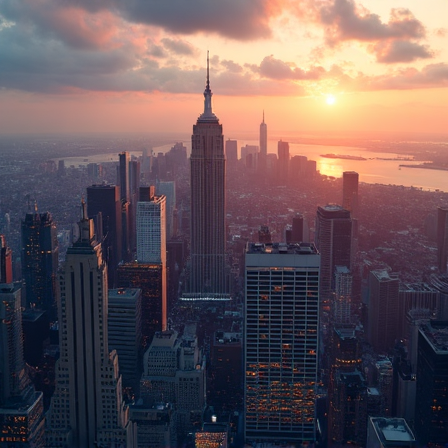

In [19]:
printmd(f"**Prompt**: {config.prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP4** Precision\n")
print(f"[I] Starting image generation with dimensions: {config.width} x {config.height} and {config.num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {config.guidance_scale} and seed {config.seed}")

_, image_paths = pipeline.infer(prompt=config.prompt,
                                batch_size=config.batch_size,
                                height=config.height,
                                width=config.width,
                                seed=config.seed,
                                num_inference_steps=config.num_inference_steps,
                                guidance_scale=config.guidance_scale,
                                save_path=DEMO_CACHE_DIR)
timing_dict = pipeline.timing_data.to_dict()

printmd(f"**Generated Image(s) in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**")
for image_path in image_paths:
    display_image_from_path(image_path)

with Output():
    pipeline.cleanup(); del pipeline; torch.cuda.empty_cache(); gc.collect()

# 6. Low VRAM Mode
In cases where GPU memory is limited, low-VRAM mode can help by offloading pipeline components to CPU. Note that the additional memory copies can add overhead to the end-to-end time.

In [20]:
config = GenerationConfig(
    height=448,
    width=448,
    batch_size=1,
    seed=1025,
    num_inference_steps=50,
    guidance_scale=4.0,
    prompt="A dramatic cityscape from a dazzling angle"
)

In [21]:
pipeline, jit_times = prepare_pipeline(
    config=config,
    precision="fp4",
    shape_mode="static",
    enable_runtime_cache=True,
    low_vram=True,
    verbose=False
)

[2025-10-28 12:27:16] [rtx_demo.utils.path_manager] [INFO] PathManager initialized - Cache: C:\tmp\demo_cache, Mode: full
[2025-10-28 12:27:17] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Shape configuration: {'clip_text_encoder': 'static', 't5_text_encoder': 'static', 'transformer': 'static', 'vae_decoder': 'static'}
[2025-10-28 12:27:18] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Activating engines...
[2025-10-28 12:27:18] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Engines activated successfully


**Prompt**: A dramatic cityscape from a dazzling angle


**Compiled** with <span style='color: #76B900; font-weight: bold'>TensorRT-RTX</span> and Transformer in **FP4** Precision with Dynamic Shapes


[I] Starting image generation with dimensions: 448 x 448 and 50 denoising iterations
[I] Using guidance_scale 4.0 and seed 1025
[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_t5_text_encoder\bf16\flux_t5_text_encoder_static.engine


[2025-10-28 12:27:21] [rtx_demo.utils.engine] [INFO] Loading runtime cache from C:/tmp/demo_cache/runtime.cache
[2025-10-28 12:27:21] [rtx_demo.utils.engine] [INFO] Deserializing runtime cache


[I] Saving Runtime cache to C:/tmp/demo_cache/runtime.cache


[2025-10-28 12:27:28] [rtx_demo.utils.engine] [INFO] Unloading TensorRT engine: C:\tmp\demo_cache\shared\engines\flux_t5_text_encoder\bf16\flux_t5_text_encoder_static.engine
[2025-10-28 12:27:28] [rtx_demo.utils.engine] [INFO] Loading runtime cache from C:/tmp/demo_cache/runtime.cache
[2025-10-28 12:27:28] [rtx_demo.utils.engine] [INFO] Deserializing runtime cache


[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_clip_text_encoder\bf16\flux_clip_text_encoder_static.engine
[I] Saving Runtime cache to C:/tmp/demo_cache/runtime.cache


[2025-10-28 12:27:35] [rtx_demo.utils.engine] [INFO] Unloading TensorRT engine: C:\tmp\demo_cache\shared\engines\flux_clip_text_encoder\bf16\flux_clip_text_encoder_static.engine


[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_transformer\fp4\flux_transformer_static.engine


[2025-10-28 12:27:37] [rtx_demo.utils.engine] [INFO] Loading runtime cache from C:/tmp/demo_cache/runtime.cache
[2025-10-28 12:27:37] [rtx_demo.utils.engine] [INFO] Deserializing runtime cache


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

[I] Saving Runtime cache to C:/tmp/demo_cache/runtime.cache


[2025-10-28 12:27:48] [rtx_demo.utils.engine] [INFO] Unloading TensorRT engine: C:\tmp\demo_cache\shared\engines\flux_transformer\fp4\flux_transformer_static.engine
[2025-10-28 12:27:49] [rtx_demo.utils.engine] [INFO] Loading runtime cache from C:/tmp/demo_cache/runtime.cache
[2025-10-28 12:27:49] [rtx_demo.utils.engine] [INFO] Deserializing runtime cache


[I] Loading bytes from C:\tmp\demo_cache\shared\engines\flux_vae_decoder\bf16\flux_vae_decoder_static.engine
[I] Saving Runtime cache to C:/tmp/demo_cache/runtime.cache


[2025-10-28 12:27:56] [rtx_demo.utils.engine] [INFO] Unloading TensorRT engine: C:\tmp\demo_cache\shared\engines\flux_vae_decoder\bf16\flux_vae_decoder_static.engine
[2025-10-28 12:27:56] [rtx_demo.flux1.dev.pipelines.flux_pipeline] [INFO] Saving image 1 / 1 to: C:/tmp/demo_cache/flux_demo_1.png with shape (448, 448, 3)


**Generated Image(s) with Low-VRAM mode in 38.15s**


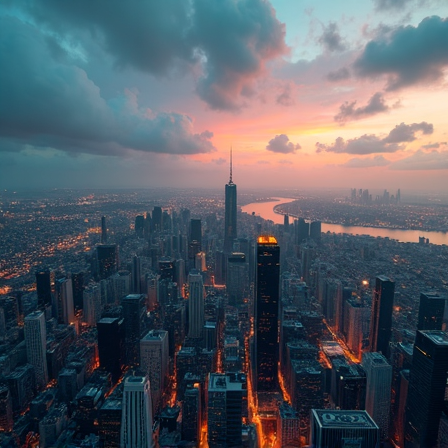

In [22]:
printmd(f"**Prompt**: {config.prompt}\n")
printmd(f"**Compiled** with {markdown_bold_green_format('TensorRT-RTX')} and Transformer in **FP4** Precision with Dynamic Shapes\n")
print(f"[I] Starting image generation with dimensions: {config.width} x {config.height} and {config.num_inference_steps} denoising iterations")
print(f"[I] Using guidance_scale {config.guidance_scale} and seed {config.seed}")

_, image_paths = pipeline.infer(prompt=config.prompt,
                                batch_size=config.batch_size,
                                height=config.height,
                                width=config.width,
                                seed=config.seed,
                                num_inference_steps=config.num_inference_steps,
                                guidance_scale=config.guidance_scale,
                                save_path=DEMO_CACHE_DIR)
timing_dict = pipeline.timing_data.to_dict()

printmd(f"**Generated Image(s) with Low-VRAM mode in {round(timing_dict['total_e2e_runtime_ms'] / 1000, 2)}s**")
for image_path in image_paths:
    display_image_from_path(image_path)

with Output():
    pipeline.cleanup(); del pipeline; torch.cuda.empty_cache(); gc.collect()